In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [29]:
# data = pd.read_csv('TANKTEMP092_098.txt',delimiter="\t", header=None, names=["date", "value"])
data = pd.read_csv('TANKTemp060_098.csv',sep=",", header=None, names=["date", "value"])

In [30]:
data.head()

,date,value
0,2015-060-00:00:30.114,18.744939
1,2015-060-00:00:30.882,18.744900
2,2015-060-00:02:38.114,18.785425
3,2015-060-00:02:38.882,18.785400
4,2015-060-00:04:46.114,18.785425


In [31]:
data.shape

(32122, 2)

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32122 entries, 0 to 32121
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          32122 non-null  object 
 1   value         32119 non-null  float64
 2   StandardTime  32122 non-null  object 
dtypes: float64(1), object(2)
memory usage: 753.0+ KB


In [32]:
data['StandardTime']=0
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,0
1,2015-060-00:00:30.882,18.744900,0
2,2015-060-00:02:38.114,18.785425,0
3,2015-060-00:02:38.882,18.785400,0
4,2015-060-00:04:46.114,18.785425,0


In [33]:
import calendar
import datetime

for i in range(len(data)):
    dd=data['date'][i].split('-')
    yy=int(dd[0])
    jd=int(dd[1])
    sec=dd[2].split(':')
    ss=sec[2][:-4]
    mm=sec[2][-3:]
    month = 1
    day = 0
    while jd - calendar.monthrange(yy,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(yy,month)[1]
        month = month + 1

    data['StandardTime'][i]=datetime.datetime(yy, month, jd, int(sec[0]),int(sec[1]),int(ss),int(mm)*1000)

In [34]:
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [106]:
data_std = data.copy()
data_std.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [107]:
data_std.drop('date', axis=1, inplace=True)
data_std.head()

,value,StandardTime
0,18.744939,2015-03-01 00:00:30.114000
1,18.744900,2015-03-01 00:00:30.882000
2,18.785425,2015-03-01 00:02:38.114000
3,18.785400,2015-03-01 00:02:38.882000
4,18.785425,2015-03-01 00:04:46.114000


In [108]:
data_std.StandardTime = pd.to_datetime(data_std.StandardTime)
data_std = data_std.set_index('StandardTime')

In [109]:
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [110]:
len(data_std)

32122

In [111]:
data_std.shape

(32122, 1)

Text(0.5, 0, 'Time')

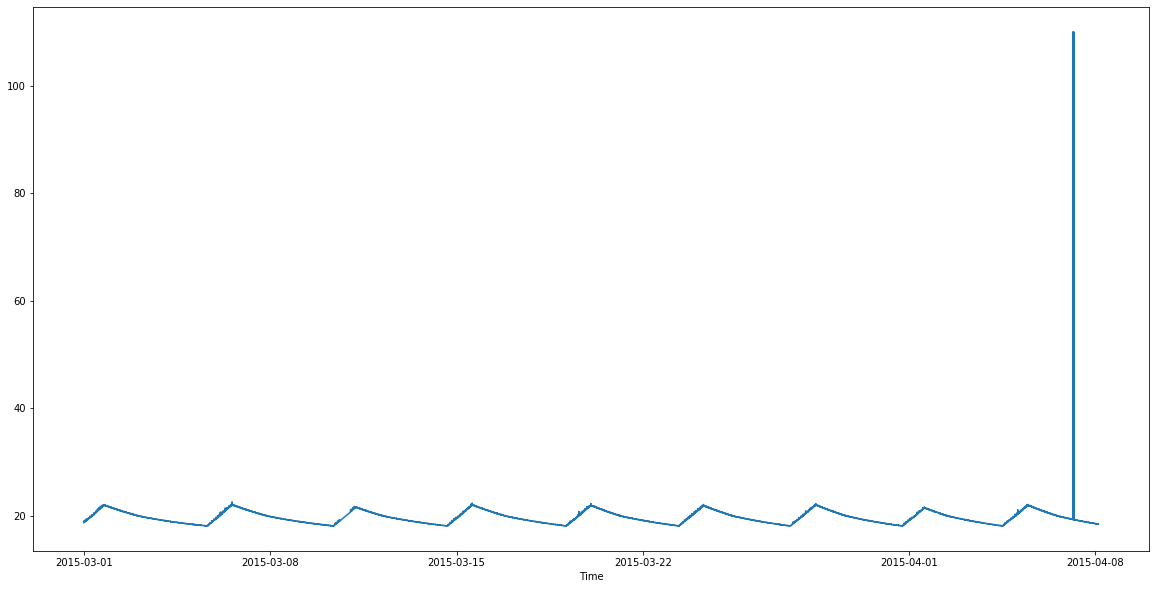

In [112]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

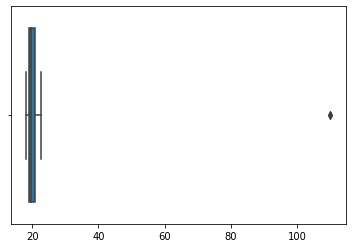

In [113]:
import seaborn as sns

sns.boxplot(data_std)

In [114]:
data_std['value'].max()

110.0

In [115]:
data_std.describe()

,value
count,32119.000000
mean,19.852985
std,1.293697
min,18.137652
25%,18.947368
50%,19.716599
75%,20.752688
max,110.000000


In [116]:
qt = data_std.quantile([.25,.5,.75])
qt

,value
0.25,18.947368
0.50,19.716599
0.75,20.752688


In [117]:
qt1 = data_std.quantile([.25])
qt1=float(qt1.to_numpy())
qt3 = data_std.quantile([.75])
qt3 = float(qt3.to_numpy())
print(qt1,qt3)
print(type(qt3))

18.947368 20.752688
<class 'float'>


In [118]:
float(qt1)

18.947368

In [119]:
qt1+qt3

39.700056000000004

In [120]:
# calculate max value of boxplot
max_box = qt3+(1.5*(qt3-qt1))
max_box

23.460668

In [121]:
# remove outlier
data_std.drop(data_std[data_std['value']>max_box].index, inplace=True)

In [123]:
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [125]:
data_std.shape

(32120, 1)

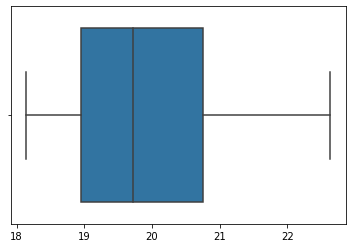

In [126]:
sns.boxplot(data_std)

Text(0.5, 0, 'Time')

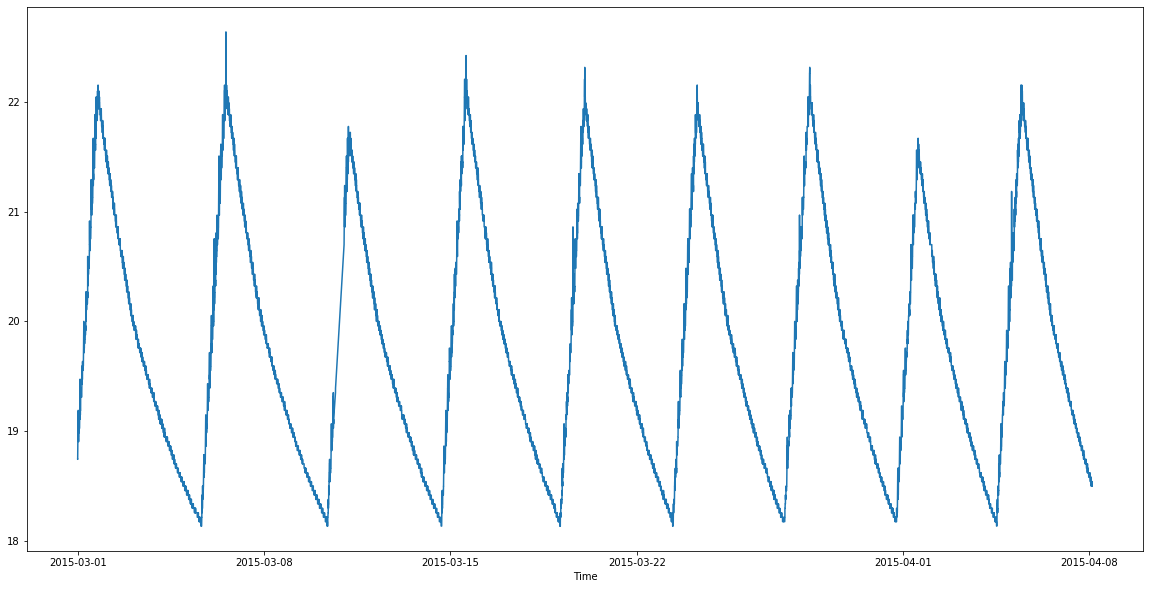

In [127]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

## Distribution 

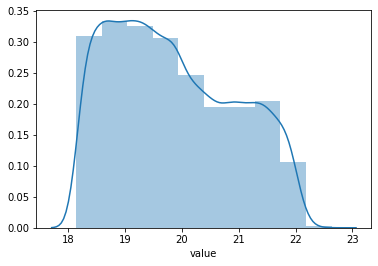

In [155]:
sns.distplot(data_std['value'],bins=10)

In [157]:
# random
import random as rd

data_ran = rd.sample(data_std, k=9000)
# sns.distplot(data_ran['value'],bins=10)

TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [259]:
data_rd = data_std.sample(frac=.1, random_state=20)
data_rd

,value
StandardTime,
2015-04-04 15:05:58.882,18.623500
2015-03-24 07:32:46.114,21.881720
2015-04-02 20:31:26.110,19.595142
2015-04-03 07:47:42.114,19.068826
2015-03-19 22:18:06.114,21.505376
...,...
2015-03-08 08:19:42.103,19.554656
2015-03-12 15:30:38.871,19.595100
2015-03-02 10:31:58.114,20.913978


In [260]:
data_rd.shape

(3212, 1)

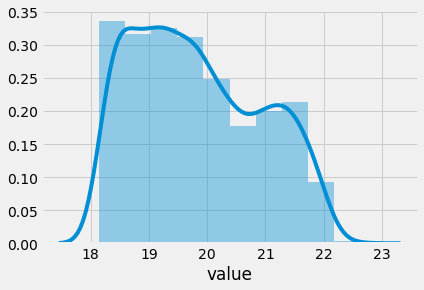

In [261]:
sns.distplot(data_rd['value'],bins=10)

Text(0.5, 1.0, 'Random data')

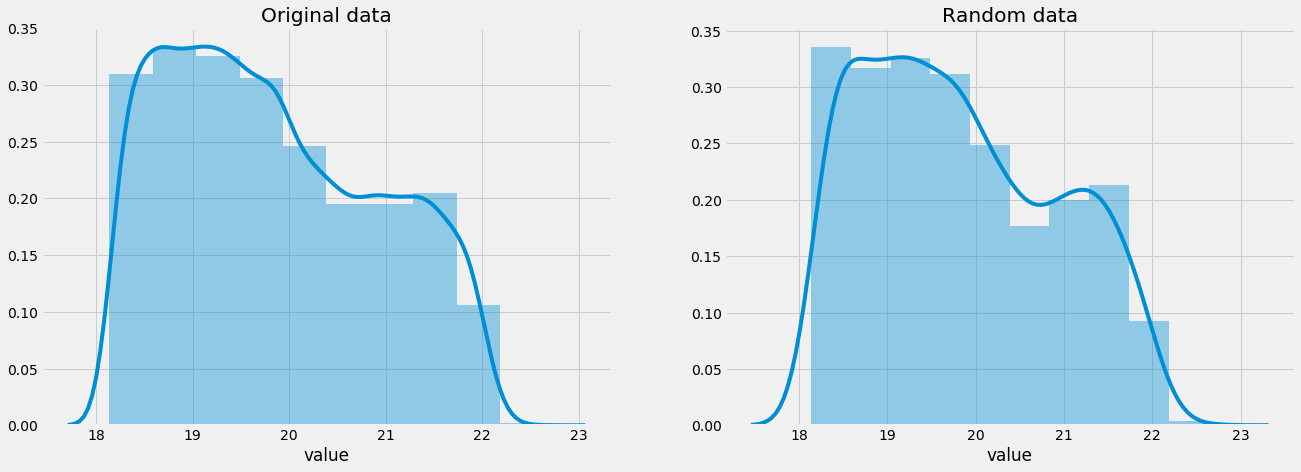

In [262]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
sns.distplot(data_std['value'],bins=10)
plt.title('Original data')
plt.subplot(2,2,2)
sns.distplot(data_rd['value'],bins=10)
plt.title('Random data')

In [263]:
data_rd

,value
StandardTime,
2015-04-04 15:05:58.882,18.623500
2015-03-24 07:32:46.114,21.881720
2015-04-02 20:31:26.110,19.595142
2015-04-03 07:47:42.114,19.068826
2015-03-19 22:18:06.114,21.505376
...,...
2015-03-08 08:19:42.103,19.554656
2015-03-12 15:30:38.871,19.595100
2015-03-02 10:31:58.114,20.913978


In [264]:
print(type(data_std))
print(type(data_rd))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


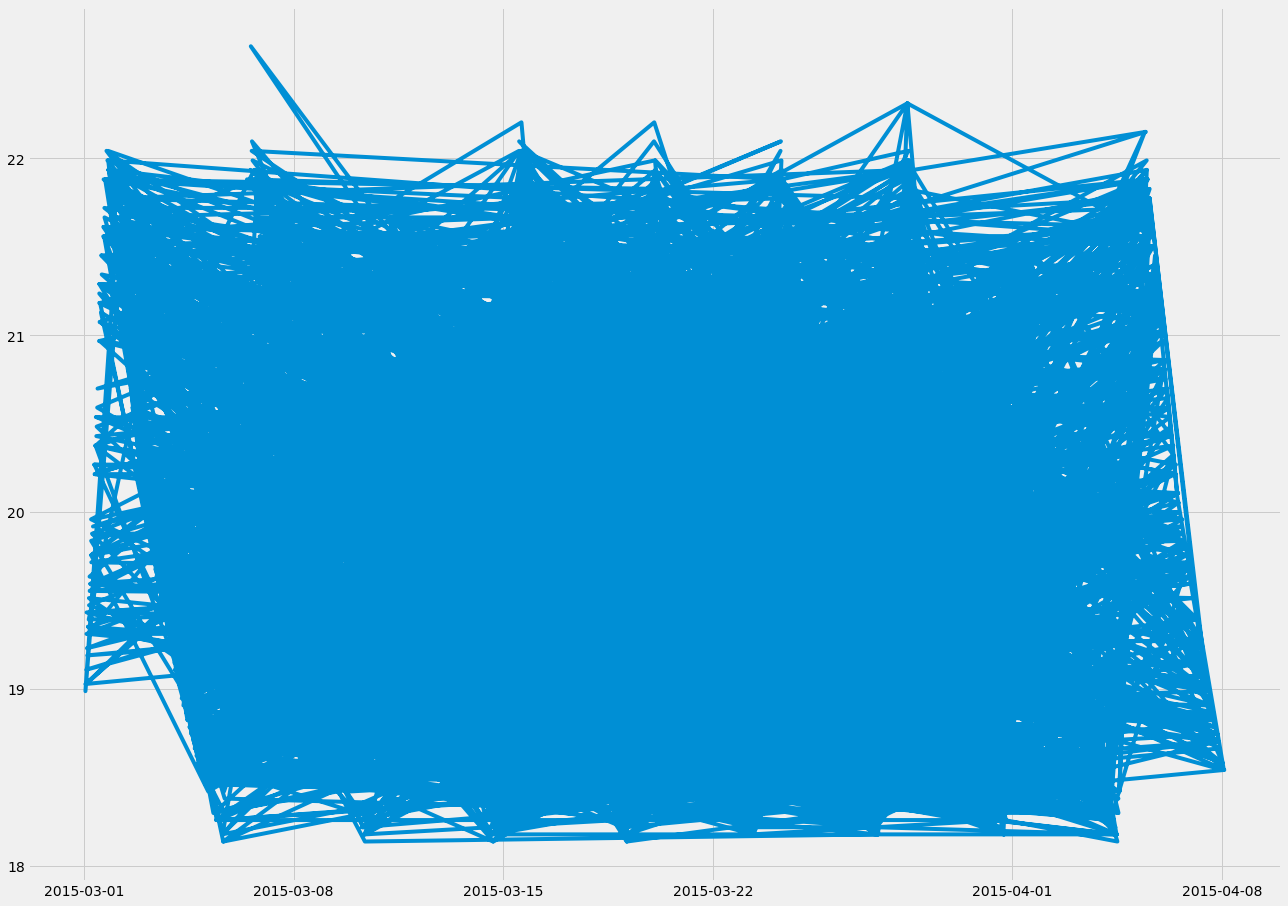

In [265]:
plt.figure(figsize=(20,15))
plt.plot(data_rd)

# data_rd.plot()

In [128]:
df = data_std.copy()
df.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [139]:
test_size = 1000
train, test  = df[:-test_size], df[-test_size:]

In [140]:
print('Train size = ' ,train.shape[0])
print('Test size = ' ,test.shape[0])

Train size =  31120
Test size =  1000


In [141]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [147]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 2/10
3111/3111 [==============================] - 34s 11ms/step - loss: nan
Epoch 3/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 4/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 5/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 6/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 7/10
3111/3111 [==============================] - 32s 10ms/step - loss: nan
Epoch 8/10
3111/3111 [==============================] - 33s 11ms/step - loss: nan
Epoch 9/10
3111/3111 [==============================] - 34s 11ms/step - loss: nan
Epoch 10/10
3111/3111 [==============================] - 34s 11ms/step - loss: nan


In [149]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)

In [ ]:
from pan

In [151]:
# Normalization the dataset

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(df)

In [152]:
dataset

array([[0.13505026],
       [0.13504159],
       [0.14405366],
       ...,
       [0.09003351],
       [0.09003351],
       [0.08103011]])

## Predict

In [219]:
df_pre = data_std.copy()

In [221]:
df_pre.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [220]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

In [224]:
#Convert the dataframe to a numpy array
dataset = df_pre.values

In [225]:
dataset

array([[18.744939],
       [18.7449  ],
       [18.785425],
       ...,
       [18.54251 ],
       [18.54251 ],
       [18.502024]])

In [226]:
#Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8 )

In [227]:
training_data_len

25696

In [228]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.13505026],
       [0.13504159],
       [0.14405366],
       ...,
       [0.09003351],
       [0.09003351],
       [0.08103011]])

In [230]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []



for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [231]:
#Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [232]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(25636, 60, 1)

In [233]:
x_train

array([[[0.13505026],
        [0.13504159],
        [0.14405366],
        ...,
        [0.18907041],
        [0.18907041],
        [0.18907041]],

       [[0.13504159],
        [0.14405366],
        [0.1440481 ],
        ...,
        [0.18907041],
        [0.18907041],
        [0.18907041]],

       [[0.14405366],
        [0.1440481 ],
        [0.14405366],
        ...,
        [0.18907041],
        [0.18907041],
        [0.18907041]],

       ...,

       [[0.14405366],
        [0.1440481 ],
        [0.15305705],
        ...,
        [0.13505026],
        [0.13505026],
        [0.13505026]],

       [[0.1440481 ],
        [0.15305705],
        [0.15305461],
        ...,
        [0.13505026],
        [0.13505026],
        [0.13505026]],

       [[0.15305705],
        [0.15305461],
        [0.14405366],
        ...,
        [0.13505026],
        [0.13505026],
        [0.13505026]]])

In [234]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [235]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [236]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
25636/25636 [==============================] - 722s 28ms/step - loss: nan


In [237]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [238]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [239]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [240]:
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [241]:
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

nan

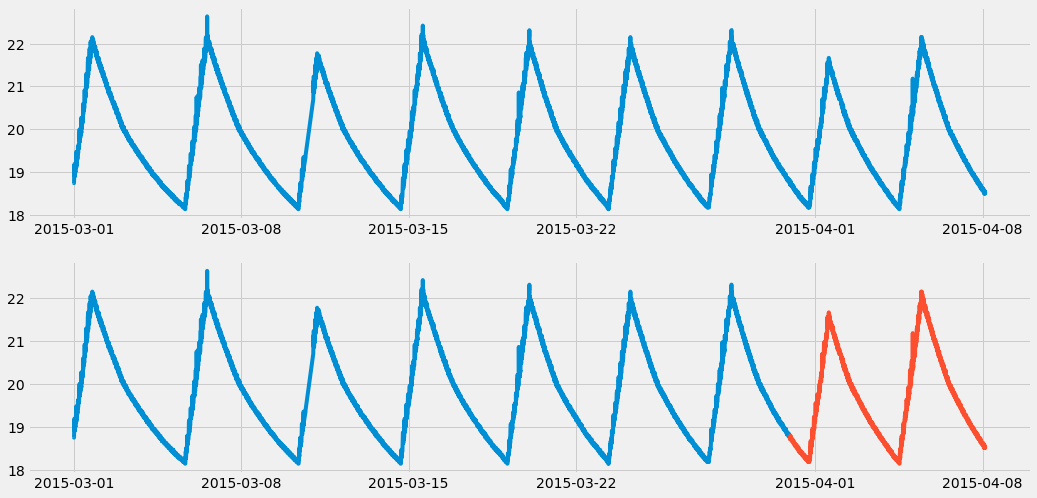

In [252]:
train = df_pre[:training_data_len]
valid = df_pre[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(df_pre['value'])

plt.subplot(2,1,2)
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
# plt.plot(train['Predictions'])

plt.show()

In [253]:
valid

,value,Predictions
StandardTime,,
2015-03-30 22:39:26.114,18.744939,NaN
2015-03-30 22:41:34.114,18.744939,NaN
2015-03-30 22:43:42.114,18.744939,NaN
2015-03-30 22:45:50.114,18.744939,NaN
2015-03-30 22:47:58.114,18.744939,NaN
...,...,...
2015-04-08 02:25:34.114,18.502024,NaN
2015-04-08 02:27:42.114,18.502024,NaN
2015-04-08 02:29:50.110,18.542510,NaN


In [258]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6424 entries, 2015-03-30 22:39:26.114000 to 2015-04-08 02:34:06.114000
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        6423 non-null   float64
 1   Predictions  0 non-null      float32
dtypes: float32(1), float64(1)
memory usage: 125.5 KB
